# Blind Source Separation with FastICA (Cocktail Party)

Steps:
1. Download two short audio clips (speech + music) as sources.
2. Normalize and optionally truncate to equal length.
3. Create linear mixtures with random 2x2 mixing matrix.
4. Apply FastICA to recover independent components.
5. Evaluate via absolute correlation between recovered and true sources.
6. Plot waveforms before and after separation.

Implementation uses only NumPy + SciPy (no scikit-learn FastICA helper) to show algorithm internals.


Download failed for https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav -> <urlopen error [Errno 11001] getaddrinfo failed>
Using synthetic fallback sources.
Sources shape: (2, 160000) Sample rate: 16000
Estimated sources shape: (2, 160000)
Absolute correlation matrix
 [[1.04683027e-04 9.99999995e-01]
 [9.99999995e-01 1.04683022e-04]]
Final correlations (matched): [0.99999999 0.99999999]


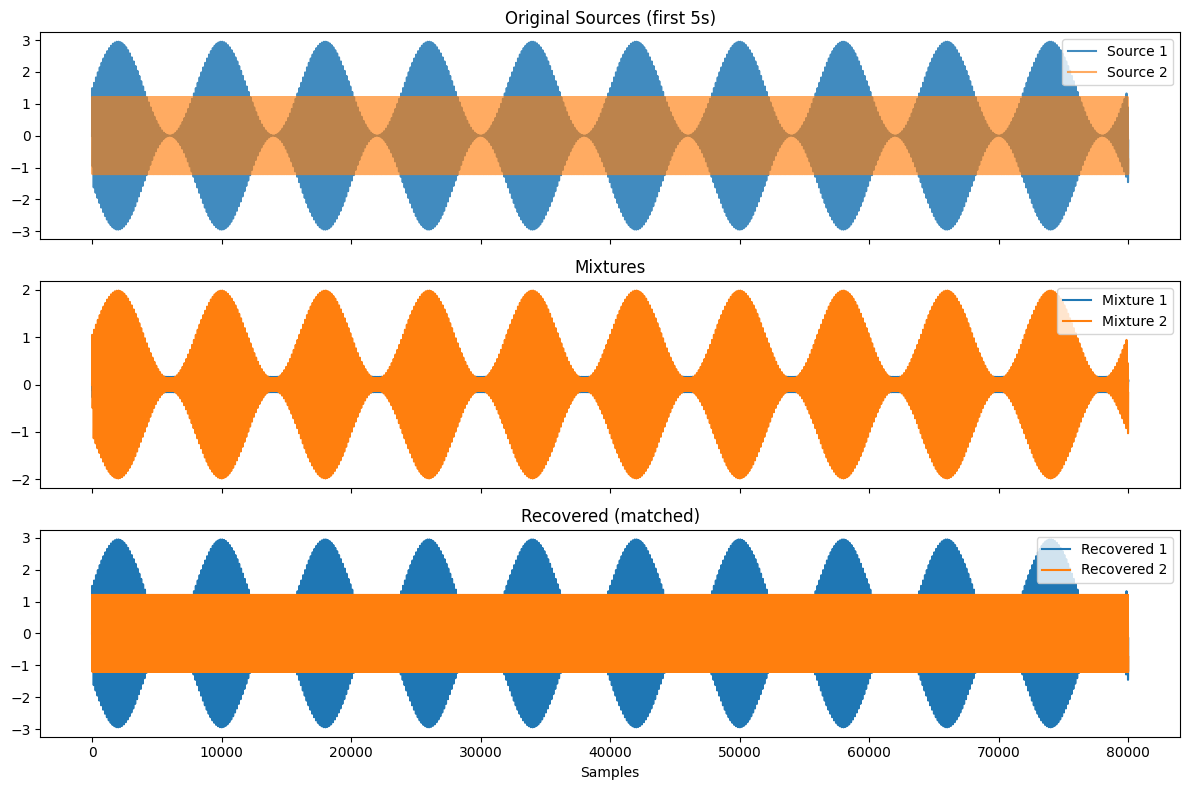

In [2]:
import numpy as np
import urllib.request, pathlib, os, io, math
from scipy.io import wavfile
import matplotlib.pyplot as plt

DATA_DIR = pathlib.Path('data_audio')
DATA_DIR.mkdir(exist_ok=True)

SOURCES = [
    ('speech.wav', 'https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav'),
    ('music.wav',  'https://www2.cs.uic.edu/~i101/SoundFiles/Fanfare60.wav')
]

def load_or_generate_sources(target_sr=16000, max_seconds=10):
    raw_signals = []
    sample_rates = []
    download_failed = False
    for fname, url in SOURCES:
        out_path = DATA_DIR / fname
        if not out_path.exists():
            try:
                print('Downloading', url)
                urllib.request.urlretrieve(url, out_path)
            except Exception as e:
                print('Download failed for', url, '->', e)
                download_failed = True
                break
        try:
            if out_path.exists():
                sr, data = wavfile.read(out_path)
                sample_rates.append(sr)
                if data.ndim == 2:
                    data = data.mean(axis=1)
                data = data.astype(np.float32)
                data = (data - data.mean()) / (data.std() + 1e-9)
                raw_signals.append(data)
        except Exception as e:
            print('Read failed, will fallback:', e)
            download_failed = True
            break
    if download_failed or len(raw_signals) < 2:
        print('Using synthetic fallback sources.')
        sr = target_sr
        t = np.linspace(0, max_seconds, sr*max_seconds, endpoint=False)
        # Source 1: amplitude modulated speech-like waveform
        envelope = 0.5*(1+np.sin(2*np.pi*2*t))
        s1 = envelope*(np.sin(2*np.pi*220*t) + 0.5*np.sin(2*np.pi*330*t))
        # Source 2: music / percussive-like: mixture of harmonics + nonlinearity
        s2 = (np.sin(2*np.pi*440*t) + 0.3*np.sin(2*np.pi*880*t) + 0.15*np.sin(2*np.pi*1320*t))
        s2 = np.tanh(2*s2)  # add non-Gaussianity
        s1 = (s1 - s1.mean())/s1.std()
        s2 = (s2 - s2.mean())/s2.std()
        return np.vstack([s1, s2]), sr
    # Truncate to same length and max_seconds
    min_len = min(len(s) for s in raw_signals)
    sr0 = sample_rates[0]
    target_len = min(min_len, sr0*max_seconds)
    S = np.vstack([s[:target_len] for s in raw_signals])
    return S, sr0

# 1 & 2. Load or generate, normalize already done inside
S, sr = load_or_generate_sources()
T = S.shape[1]
print('Sources shape:', S.shape, 'Sample rate:', sr)

# 3. Mix
rng = np.random.default_rng(0)
A = rng.normal(size=(2,2))
X = A @ S
X_centered = X - X.mean(axis=1, keepdims=True)

# Whitening
cov = np.cov(X_centered)
E, D = np.linalg.eigh(cov)
idx = np.argsort(E)[::-1]
E, D = E[idx], D[:, idx]
D_inv_sqrt = np.diag(1.0/np.sqrt(E + 1e-12))
whitening = D @ D_inv_sqrt @ D.T
X_white = whitening @ X_centered

# 4. FastICA (deflation)

def fastica_deflation(Xw, n_comp=2, max_iter=1000, tol=1e-6, nonlin='tanh'):
    n_features, n_samples = Xw.shape
    W = np.zeros((n_comp, n_features))
    for p in range(n_comp):
        w = rng.normal(size=n_features)
        w /= np.linalg.norm(w)
        for it in range(max_iter):
            y = w @ Xw
            if nonlin == 'tanh':
                g = np.tanh(y)
                g_prime = 1 - g**2
            elif nonlin == 'cube':
                g = y**3
                g_prime = 3*y**2
            else:
                raise ValueError('Unknown nonlinearity')
            w_new = (Xw * g).mean(axis=1) - g_prime.mean()*w
            if p > 0:
                w_new -= W[:p].T @ (W[:p] @ w_new)
            w_new /= np.linalg.norm(w_new) + 1e-12
            if np.abs(np.abs(np.dot(w_new, w)) - 1) < tol:
                w = w_new
                break
            w = w_new
        W[p] = w
    return W

W_ica = fastica_deflation(X_white, n_comp=2)
S_est_white = W_ica @ X_white
W_total = W_ica @ whitening
S_est = W_total @ X_centered

print('Estimated sources shape:', S_est.shape)

# 5. Correlation evaluation
true = S
est = S_est
true_n = (true - true.mean(axis=1, keepdims=True)) / (true.std(axis=1, keepdims=True)+1e-12)
est_n = (est - est.mean(axis=1, keepdims=True)) / (est.std(axis=1, keepdims=True)+1e-12)
C = np.abs(true_n @ est_n.T / true.shape[1])
print('Absolute correlation matrix\n', C)
if C[0,1] + C[1,0] > C[0,0] + C[1,1]:
    est = est[[1,0]]
    C = C[[1,0]]
print('Final correlations (matched):', np.diag(C))

# 6. Plot
sec = 5
disp_len = min(int(sec*sr), T)
fig, axes = plt.subplots(3,1, figsize=(12,8), sharex=True)
axes[0].plot(true[0,:disp_len], label='Source 1', alpha=0.85)
axes[0].plot(true[1,:disp_len], label='Source 2', alpha=0.65)
axes[0].set_title('Original Sources (first 5s)'); axes[0].legend(loc='upper right')
axes[1].plot(X[0,:disp_len], label='Mixture 1')
axes[1].plot(X[1,:disp_len], label='Mixture 2')
axes[1].set_title('Mixtures'); axes[1].legend(loc='upper right')
axes[2].plot(est[0,:disp_len], label='Recovered 1')
axes[2].plot(est[1,:disp_len], label='Recovered 2')
axes[2].set_title('Recovered (matched)'); axes[2].legend(loc='upper right')
axes[2].set_xlabel('Samples')
plt.tight_layout()
plt.show()
